# Masked Autoencoders's Visualization Demo
### Visulization demo using pre-trained MAE model.
### Source: https://github.com/facebookresearch/mae

## Cloning from MAE repository 

In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.5 MB/s eta 0:00:00
Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), 829.52 KiB | 4.82 MiB/s, done.


### Defining utils

###Implementation of random masking with different masking ratio, block-like masking and grid-like masking

In [25]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, mask_ratio):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()


##Loading a pre-trained MAE model

In [4]:
#download checkpoint
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


##Loading a random image (Human Face)

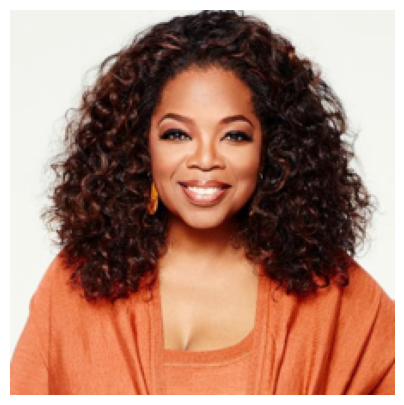

In [5]:
# load an image
img_url = 'https://legendsrevealed.com/entertainment/wp-content/uploads/2014/01/HPYrGBlP.jpeg'
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

## Running MAE on the image with masking ratio 75%

MAE with pixel reconstruction:


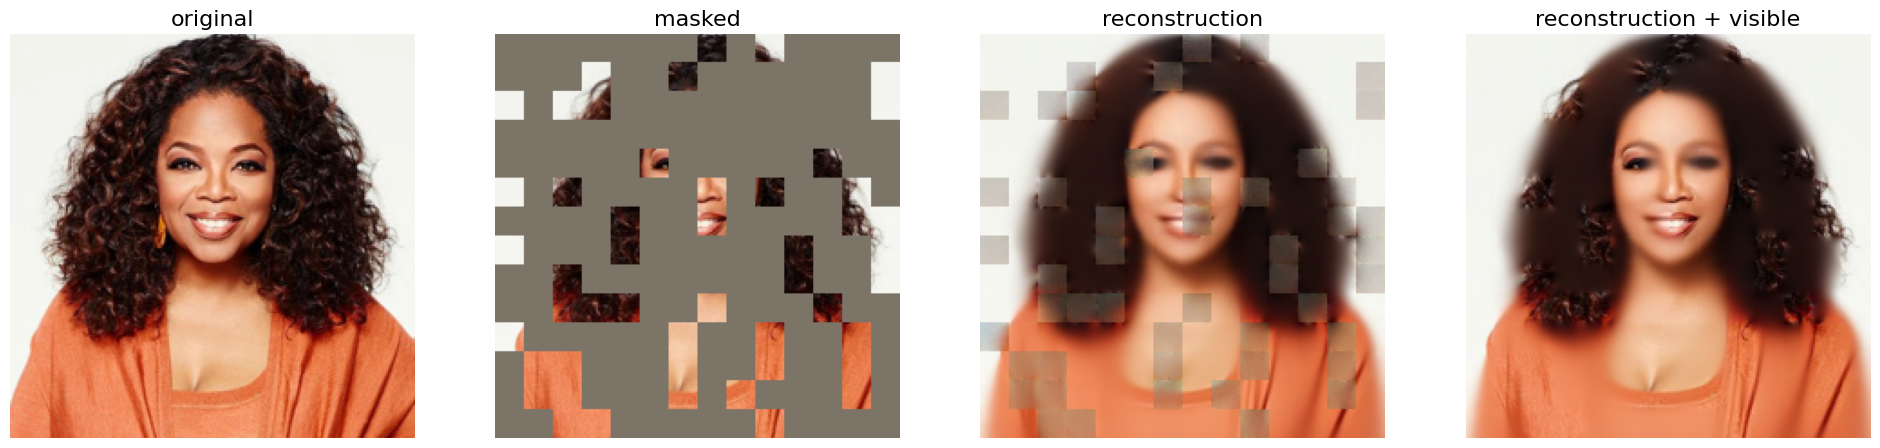

In [26]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae, mask_ratio = 0.75)

## Running MAE on the image with masking ratio 85%


MAE with pixel reconstruction:


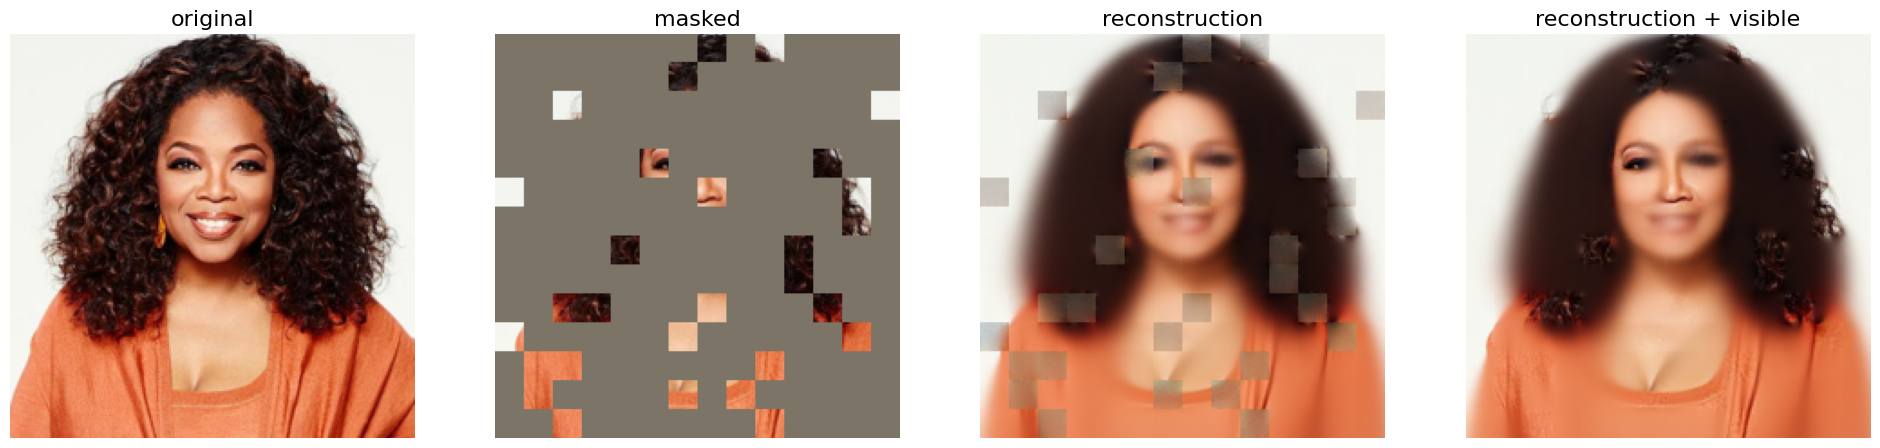

In [27]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae, mask_ratio=0.85)

### Experimenting MAE model with GAN loss for more realistic generation

In [29]:
# download checkpoint
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

--2023-06-11 11:50:44--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.162.120, 108.157.162.108, 108.157.162.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.162.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large_ganloss.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  63.7MB/s    in 17s     

2023-06-11 11:51:01 (75.0 MB/s) - ‘mae_visualize_vit_large_ganloss.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


###Running MAE on image with masking ratio 75% + GAN loss

MAE with extra GAN loss:


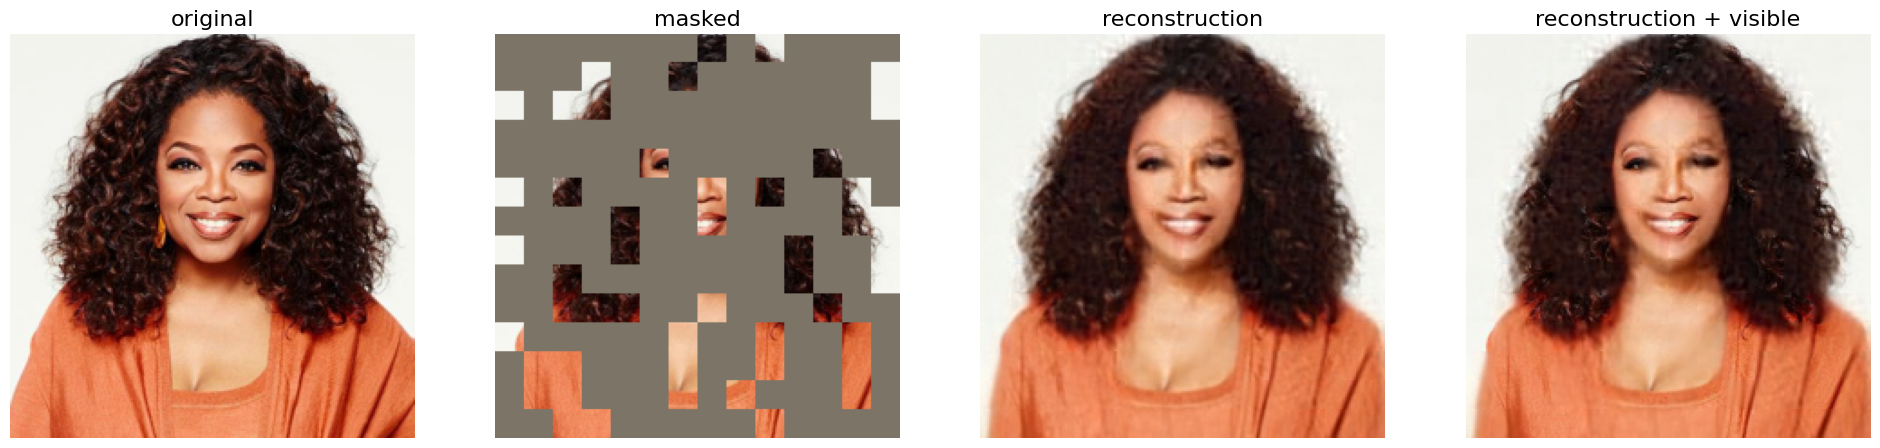

In [30]:
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan, mask_ratio = 0.75)

##Running MAE on image with masking ratio 85% + GAN loss

MAE with extra GAN loss:


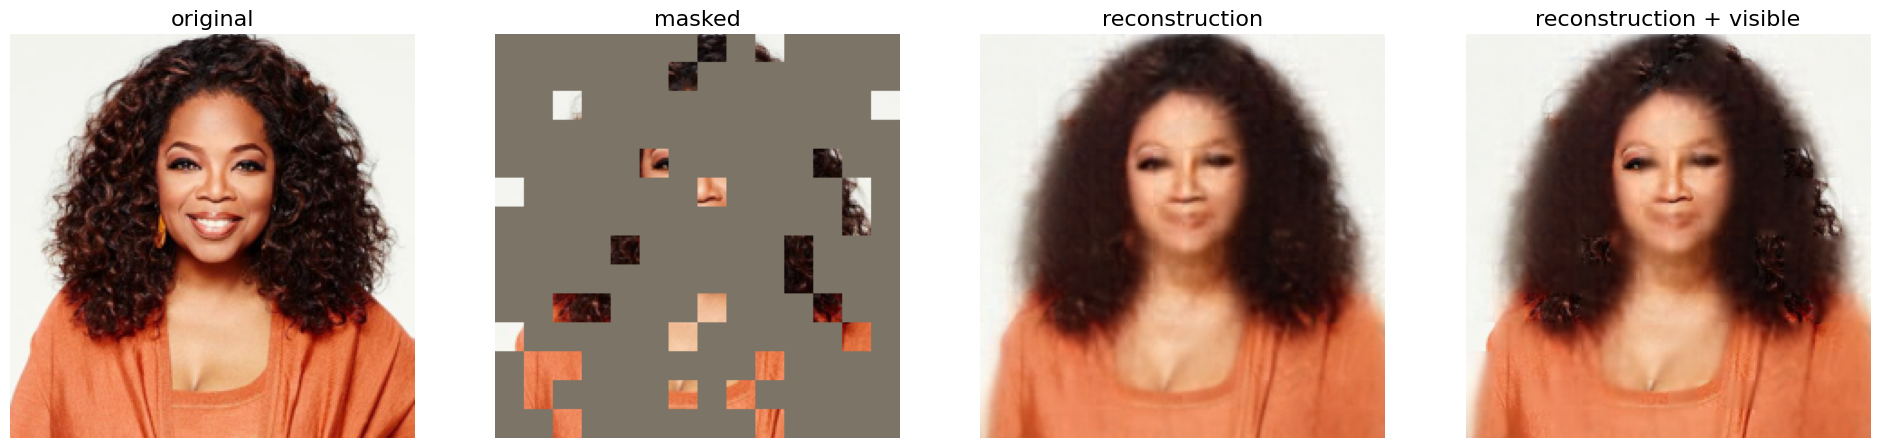

In [31]:
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan, mask_ratio = 0.85)